# Senegalese tax and benefit system from scratch

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np

from openfisca_core.columns import BoolCol, IntCol, DateCol, FloatCol
from openfisca_core.formulas import set_input_divide_by_period, set_input_dispatch_by_period
from openfisca_core.variables import Variable

from openfisca_senegal import SenegalTaxBenefitSystem
from openfisca_senegal.entities import Individus

In [3]:
tax_benefit_system = SenegalTaxBenefitSystem()

Les paramètres de la législation sont définis ci-dessous via une string XML.

Le barème de l'impôt progressif a été récupéré dans le fichier http://www.gouv.sn/IMG/pdf/cgi2013.pdf à la page 71.

In [4]:
tax_benefit_system.add_legislation_params(u'''
<NODE code="root">
  <BAREME code="bareme_impot_progressif" type="monetary">
    <TRANCHE code="tranche0">
      <SEUIL>
        <VALUE deb="2013-01-01" fuzzy="true" valeur="0" />
      </SEUIL>
      <TAUX>
        <VALUE deb="2013-01-01" fuzzy="true" valeur="0" />
      </TAUX>
    </TRANCHE>
    <TRANCHE code="tranche1">
      <SEUIL>
        <VALUE deb="2013-01-01" fuzzy="true" valeur="630000" />
      </SEUIL>
      <TAUX>
        <VALUE deb="2013-01-01" fuzzy="true" valeur="0.2" />
      </TAUX>
    </TRANCHE>
    <TRANCHE code="tranche2">
      <SEUIL>
        <VALUE deb="2013-01-01" fuzzy="true" valeur="1500000" />
      </SEUIL>
      <TAUX>
        <VALUE deb="2013-01-01" fuzzy="true" valeur="0.3" />
      </TAUX>
    </TRANCHE>
    <TRANCHE code="tranche3">
      <SEUIL>
        <VALUE deb="2013-01-01" fuzzy="true" valeur="4000000" />
      </SEUIL>
      <TAUX>
        <VALUE deb="2013-01-01" fuzzy="true" valeur="0.35" />
      </TAUX>
    </TRANCHE>
    <TRANCHE code="tranche4">
      <SEUIL>
        <VALUE deb="2013-01-01" fuzzy="true" valeur="8000000" />
      </SEUIL>
      <TAUX>
        <VALUE deb="2013-01-01" fuzzy="true" valeur="0.37" />
      </TAUX>
    </TRANCHE>
    <TRANCHE code="tranche5">
      <SEUIL>
        <VALUE deb="2013-01-01" fuzzy="true" valeur="13500000" />
      </SEUIL>
      <TAUX>
        <VALUE deb="2013-01-01" fuzzy="true" valeur="0.4" />
      </TAUX>
    </TRANCHE>
  </BAREME>
  <NODE code="reductions_pour_charge_de_famille">
    <CODE code="taux_1" format="percent">
      <VALUE deb="2013-01-01" fuzzy="true" valeur="0" />
    </CODE>
    <CODE code="taux_2" format="percent">
      <VALUE deb="2013-01-01" fuzzy="true" valeur="0.1" />
    </CODE>
    <CODE code="taux_3" format="percent">
      <VALUE deb="2013-01-01" fuzzy="true" valeur="0.15" />
    </CODE>
    <CODE code="taux_4" format="percent">
      <VALUE deb="2013-01-01" fuzzy="true" valeur="0.2" />
    </CODE>
    <CODE code="taux_5" format="percent">
      <VALUE deb="2013-01-01" fuzzy="true" valeur="0.25" />
    </CODE>
    <CODE code="taux_6" format="percent">
      <VALUE deb="2013-01-01" fuzzy="true" valeur="0.3" />
    </CODE>
    <CODE code="taux_7" format="percent">
      <VALUE deb="2013-01-01" fuzzy="true" valeur="0.35" />
    </CODE>
    <CODE code="taux_8" format="percent">
      <VALUE deb="2013-01-01" fuzzy="true" valeur="0.4" />
    </CODE>
    <CODE code="taux_9" format="percent">
      <VALUE deb="2013-01-01" fuzzy="true" valeur="0.45" />
    </CODE>
    <CODE code="min_1" type="monetary">
      <VALUE deb="2013-01-01" fuzzy="true" valeur="0" />
    </CODE>
    <CODE code="min_2" type="monetary">
      <VALUE deb="2013-01-01" fuzzy="true" valeur="100000" />
    </CODE>
    <CODE code="min_3" type="monetary">
      <VALUE deb="2013-01-01" fuzzy="true" valeur="200000" />
    </CODE>
    <CODE code="min_4" type="monetary">
      <VALUE deb="2013-01-01" fuzzy="true" valeur="300000" />
    </CODE>
    <CODE code="min_5" type="monetary">
      <VALUE deb="2013-01-01" fuzzy="true" valeur="400000" />
    </CODE>
    <CODE code="min_6" type="monetary">
      <VALUE deb="2013-01-01" fuzzy="true" valeur="500000" />
    </CODE>
    <CODE code="min_7" type="monetary">
      <VALUE deb="2013-01-01" fuzzy="true" valeur="600000" />
    </CODE>
    <CODE code="min_8" type="monetary">
      <VALUE deb="2013-01-01" fuzzy="true" valeur="700000" />
    </CODE>
    <CODE code="min_9" type="monetary">
      <VALUE deb="2013-01-01" fuzzy="true" valeur="800000" />
    </CODE>
    <CODE code="max_1" type="monetary">
      <VALUE deb="2013-01-01" fuzzy="true" valeur="0" />
    </CODE>
    <CODE code="max_2" type="monetary">
      <VALUE deb="2013-01-01" fuzzy="true" valeur="300000" />
    </CODE>
    <CODE code="max_3" type="monetary">
      <VALUE deb="2013-01-01" fuzzy="true" valeur="650000" />
    </CODE>
    <CODE code="max_4" type="monetary">
      <VALUE deb="2013-01-01" fuzzy="true" valeur="1100000" />
    </CODE>
    <CODE code="max_5" type="monetary">
      <VALUE deb="2013-01-01" fuzzy="true" valeur="1650000" />
    </CODE>
    <CODE code="max_6" type="monetary">
      <VALUE deb="2013-01-01" fuzzy="true" valeur="2030000" />
    </CODE>
    <CODE code="max_7" type="monetary">
      <VALUE deb="2013-01-01" fuzzy="true" valeur="2490000" />
    </CODE>
    <CODE code="max_8" type="monetary">
      <VALUE deb="2013-01-01" fuzzy="true" valeur="2755000" />
    </CODE>
    <CODE code="max_9" type="monetary">
      <VALUE deb="2013-01-01" fuzzy="true" valeur="3180000" />
    </CODE>
  </NODE>
</NODE>
''')

In [5]:
class id_famille(Variable):
    column = IntCol
    entity_class = Individus
    is_permanent = True
    label = u"Identifiant de la famille"

tax_benefit_system.update_variable(id_famille)


class role_dans_famille(Variable):
    column = IntCol
    entity_class = Individus
    is_permanent = True
    label = u"Rôle dans la famille"

tax_benefit_system.update_variable(role_dans_famille)


class date_de_naissance(Variable):
    column = DateCol
    entity_class = Individus
    label = u"Date de naissance"

tax_benefit_system.update_variable(date_de_naissance)


class salaire(Variable):
    column = FloatCol
    entity_class = Individus
    label = "Salaire"
    set_input = set_input_divide_by_period

tax_benefit_system.update_variable(salaire)



In [6]:
class est_marie(Variable):
    column = BoolCol
    entity_class = Individus
    label = u"Est marié"
    set_input = set_input_dispatch_by_period

tax_benefit_system.update_variable(est_marie)


class conjoint_a_des_revenus(Variable):
    column = BoolCol
    entity_class = Individus

tax_benefit_system.update_variable(conjoint_a_des_revenus)


class nombre_enfants(Variable):
    column = IntCol
    entity_class = Individus

tax_benefit_system.update_variable(nombre_enfants)

In [7]:
class nombre_de_parts(Variable):
    column = FloatCol
    entity_class = Individus
    label = u"Nombre de parts"

    def function(self, simulation, period):
        nombre_de_parts_enfants = simulation.calculate('nombre_enfants', period) * 0.5

        conjoint_a_des_revenus = simulation.calculate('conjoint_a_des_revenus', period)
        est_marie = simulation.calculate('est_marie', period)
        nombre_de_parts_conjoint = est_marie * 0.5 + (1 - conjoint_a_des_revenus) * 0.5

        nombre_de_parts = 1 + nombre_de_parts_conjoint + nombre_de_parts_enfants

        return period, np.minimum(5, nombre_de_parts)
        

tax_benefit_system.update_variable(nombre_de_parts)


class impot_avant_reduction_famille(Variable):
    column = FloatCol
    entity_class = Individus

    def function(self, simulation, period):
        salaire = simulation.calculate_add('salaire', period)
        bareme_impot_progressif = simulation.legislation_at(period.start).bareme_impot_progressif
        return period, bareme_impot_progressif.calc(salaire)

tax_benefit_system.update_variable(impot_avant_reduction_famille)


class reduction_impots_pour_charge_famille(Variable):
    column = FloatCol
    entity_class = Individus

    def function(self, simulation, period):
        impot_avant_reduction_famille = simulation.calculate('impot_avant_reduction_famille', period)
        
        nombre_de_parts = simulation.calculate('nombre_de_parts', period)
        reductions_pour_charge_de_famille = simulation.legislation_at(period.start).reductions_pour_charge_de_famille
        taux = (nombre_de_parts == 1) * reductions_pour_charge_de_famille.taux_1 + \
            (nombre_de_parts == 1.5) * reductions_pour_charge_de_famille.taux_2 + \
            (nombre_de_parts == 2) * reductions_pour_charge_de_famille.taux_3 + \
            (nombre_de_parts == 2.5) * reductions_pour_charge_de_famille.taux_4 + \
            (nombre_de_parts == 3) * reductions_pour_charge_de_famille.taux_5 + \
            (nombre_de_parts == 3.5) * reductions_pour_charge_de_famille.taux_6 + \
            (nombre_de_parts == 4) * reductions_pour_charge_de_famille.taux_7 + \
            (nombre_de_parts == 4.5) * reductions_pour_charge_de_famille.taux_8 + \
            (nombre_de_parts == 5) * reductions_pour_charge_de_famille.taux_9
        minimum = (nombre_de_parts == 1) * reductions_pour_charge_de_famille.min_1 + \
            (nombre_de_parts == 1.5) * reductions_pour_charge_de_famille.min_2 + \
            (nombre_de_parts == 2) * reductions_pour_charge_de_famille.min_3 + \
            (nombre_de_parts == 2.5) * reductions_pour_charge_de_famille.min_4 + \
            (nombre_de_parts == 3) * reductions_pour_charge_de_famille.min_5 + \
            (nombre_de_parts == 3.5) * reductions_pour_charge_de_famille.min_6 + \
            (nombre_de_parts == 4) * reductions_pour_charge_de_famille.min_7 + \
            (nombre_de_parts == 4.5) * reductions_pour_charge_de_famille.min_8 + \
            (nombre_de_parts == 5) * reductions_pour_charge_de_famille.min_9
        maximum = (nombre_de_parts == 1) * reductions_pour_charge_de_famille.max_1 + \
            (nombre_de_parts == 1.5) * reductions_pour_charge_de_famille.max_2 + \
            (nombre_de_parts == 2) * reductions_pour_charge_de_famille.max_3 + \
            (nombre_de_parts == 2.5) * reductions_pour_charge_de_famille.max_4 + \
            (nombre_de_parts == 3) * reductions_pour_charge_de_famille.max_5 + \
            (nombre_de_parts == 3.5) * reductions_pour_charge_de_famille.max_6 + \
            (nombre_de_parts == 4) * reductions_pour_charge_de_famille.max_7 + \
            (nombre_de_parts == 4.5) * reductions_pour_charge_de_famille.max_8 + \
            (nombre_de_parts == 5) * reductions_pour_charge_de_famille.max_9

        reduction_impot = np.clip(impot_avant_reduction_famille * taux, a_min=minimum, a_max=maximum)
        
        return period, reduction_impot

tax_benefit_system.update_variable(reduction_impots_pour_charge_famille)


class impot_revenus(Variable):
    column = FloatCol
    entity_class = Individus

    def function(self, simulation, period):
        impot_avant_reduction_famille = simulation.calculate('impot_avant_reduction_famille', period)
        reduction_impots_pour_charge_famille = simulation.calculate('reduction_impots_pour_charge_famille', period)
        impot_apres_reduction_famille = impot_avant_reduction_famille - reduction_impots_pour_charge_famille
        return period, np.maximum(0, impot_apres_reduction_famille)

tax_benefit_system.update_variable(impot_revenus)

In [8]:
scenario = tax_benefit_system.new_scenario()

In [9]:
scenario.init_single_entity(
    parent1={
        'salaire': 1800000,
        'est_marie': True,
        'conjoint_a_des_revenus': False,
        'nombre_enfants': 2,
    },
    period='2015',
)

In [10]:
simulation = scenario.new_simulation()

In [11]:
simulation.calculate('salaire', period='2015')

array([ 1800000.], dtype=float32)

In [12]:
simulation.calculate('impot_avant_reduction_famille', period='2015')

array([ 264000.], dtype=float32)

In [13]:
simulation.calculate('reduction_impots_pour_charge_famille', period='2015')

array([ 400000.], dtype=float32)

In [14]:
simulation.calculate('impot_revenus', period='2015')

array([ 0.], dtype=float32)

In [15]:
(1500000 - 630000) * 0.2 + (1800000 - 1500000) * 0.3

264000.0

In [16]:
simulation.calculate('nombre_de_parts', period='2015')

array([ 3.], dtype=float32)

## Simuler plusieurs cas types à la fois

In [17]:
import matplotlib.pyplot as plt
%matplotlib inline

In [22]:
scenario1 = tax_benefit_system.new_scenario()
scenario1.init_single_entity(
    parent1={
        'salaire': 1800000,
        'est_marie': True,
        'conjoint_a_des_revenus': False,
        'nombre_enfants': 0,
    },
    period='2015',
    axes=[
        {
            'count': 100,
            'min': 0,
            'max': 3e6,
            'name': 'salaire',
        }
    ],
)
simulation1 = scenario1.new_simulation()

salaire1 = simulation1.calculate('salaire', period='2015')
reduction_impots_pour_charge_famille1 = simulation1.calculate('reduction_impots_pour_charge_famille', period='2015')
impot_avant_reduction_famille1 = simulation1.calculate('impot_avant_reduction_famille', period='2015')
impot_revenus1 = simulation1.calculate('impot_revenus', period='2015')

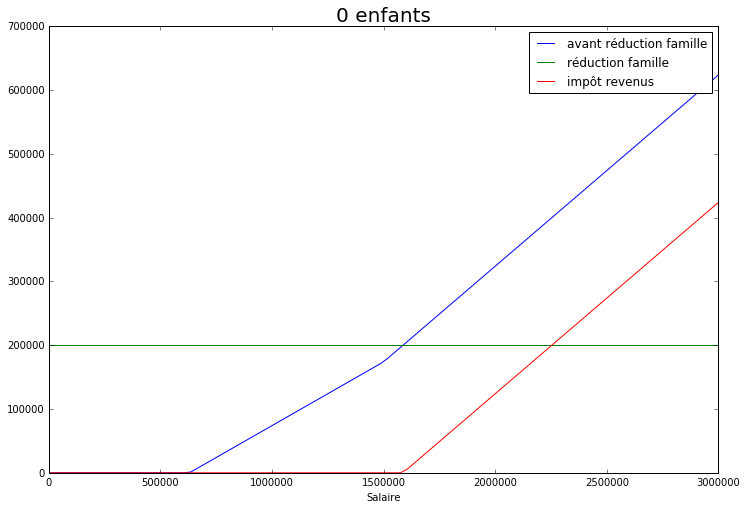

In [33]:
plt.figure(figsize=(12, 8))
plt.plot(salaire1, impot_avant_reduction_famille1, label=u'avant réduction famille')
plt.plot(salaire1, reduction_impots_pour_charge_famille1, label=u'réduction famille')
plt.plot(salaire1, impot_revenus1, label=u'impôt revenus')
plt.xlabel(u'Salaire')
plt.legend()
plt.title(u'0 enfants', fontsize=20)

In [37]:
scenario2 = tax_benefit_system.new_scenario()
scenario2.init_single_entity(
    parent1={
        'salaire': 1800000,
        'est_marie': True,
        'conjoint_a_des_revenus': False,
        'nombre_enfants': 1,
    },
    period='2015',
    axes=[
        {
            'count': 100,
            'min': 0,
            'max': 3e6,
            'name': 'salaire',
        }
    ],
)
simulation2 = scenario2.new_simulation()

salaire2 = simulation2.calculate('salaire', period='2015')
reduction_impots_pour_charge_famille2 = simulation2.calculate('reduction_impots_pour_charge_famille', period='2015')
impot_avant_reduction_famille2 = simulation2.calculate('impot_avant_reduction_famille', period='2015')
impot_revenus2 = simulation2.calculate('impot_revenus', period='2015')

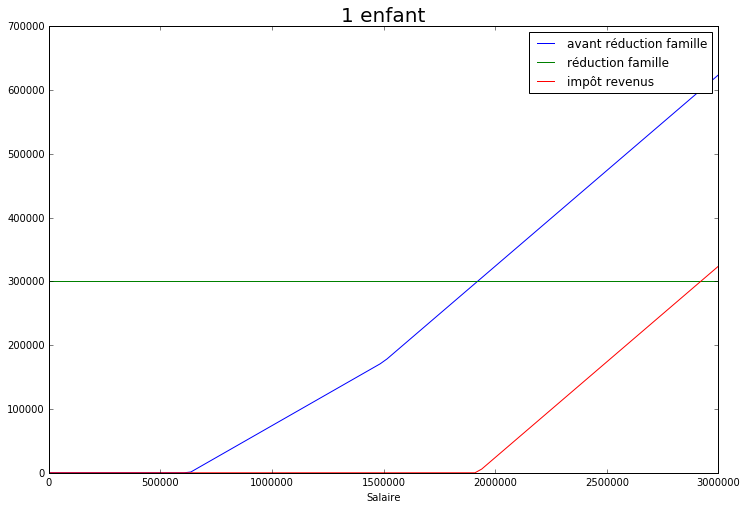

In [58]:
plt.figure(figsize=(12, 8))
plt.plot(salaire2, impot_avant_reduction_famille2, label=u'avant réduction famille')
plt.plot(salaire2, reduction_impots_pour_charge_famille2, label=u'réduction famille')
plt.plot(salaire2, impot_revenus2, label=u'impôt revenus')
plt.xlabel(u'Salaire')
plt.legend()
plt.title(u'1 enfant', fontsize=20)

(-10000.0, 3010000.0, -10000.0, 110000.0)

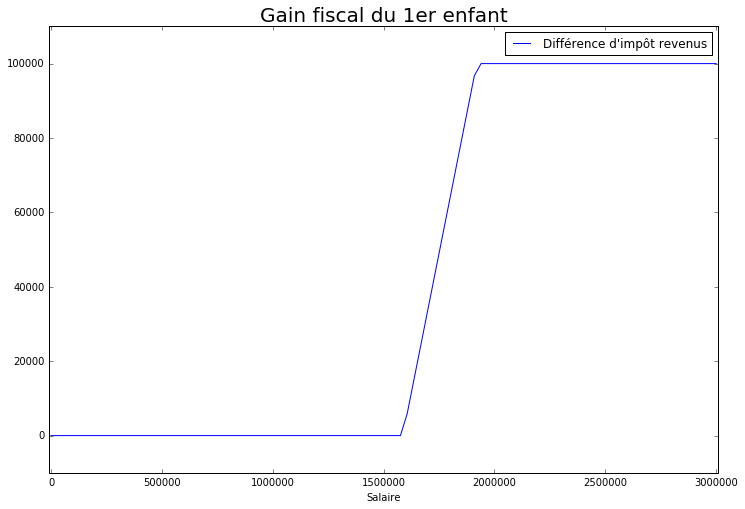

In [63]:
impot_revenus_diff = np.abs(impot_revenus2 - impot_revenus1)
plt.figure(figsize=(12, 8))
plt.plot(salaire1, impot_revenus_diff, label=u'Différence d\'impôt revenus')
plt.xlabel(u'Salaire')
plt.legend()
plt.title(u'Gain fiscal du 1er enfant', fontsize=20)

plot_margin = 10000
x0, x1, y0, y1 = plt.axis()
plt.axis((x0 - plot_margin, x1 + plot_margin, y0 - plot_margin, y1 + plot_margin))

## Affichage des taux marginaux

In [20]:
from openfisca_core import rates

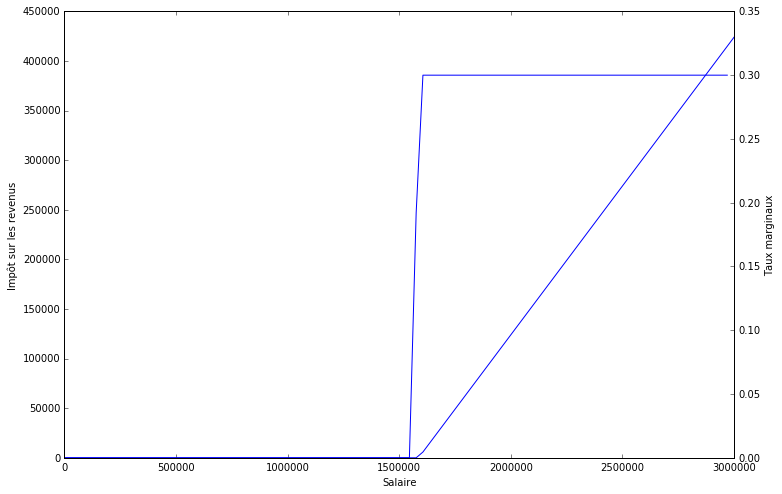

In [68]:
fig, ax1 = plt.subplots(figsize=(12, 8))

ax1.plot(salaire1, impot_revenus1)
ax1.set_xlabel(u'Salaire')
ax1.set_ylabel(u'Impôt sur les revenus')

ax2 = ax1.twinx()
ax2.set_ylabel(u'Taux marginaux')
ax2.plot(
    salaire1[:-1],
    1 - rates.marginal_rate(target=impot_revenus1, varying=salaire1),
)